# Setup for running Quantum ESPRESSO

In [1]:
! pip install -e aiida_qe_basic

Obtaining file:///home/jovyan/aiida_qe_basic
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for aiida-qe-basic (pyproject.toml) ... done
  Created wheel for aiida-qe-basic: filename=aiida_qe_basic-0.1.0-py2.py3-none-any.whl size=1300 sha256=53dd8250d377f2946284163c7ed5116ca9ab31b862765f0f60ed6890fa3ed2fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-d74o4kxf/wheels/81/99/24/e831e9f6fea84908ad4b002f9d4dc83a8da09ad5fa0d41b8b7
Successfully built aiida-qe-basic
  Attempting uninstall: aiida-qe-basic
    Found existing installation: aiida-qe-basic 0.1.0
    Uninstalling aiida-qe-basic-0.1.0:
      Successfully uninstalled aiida-qe-basic-0.1.0


In [2]:
import subprocess

In [3]:
try: 
    subprocess.check_output(["verdi", "profile", "setup", "core.sqlite_dos", "-n", "--profile", "test", "--email", "no@email.com"])
except: 
    pass

Usage: verdi profile setup core.sqlite_dos [OPTIONS]
Try 'verdi profile setup core.sqlite_dos --help' for help.

Error: Invalid value for '--profile': the profile `test` already exists


In [4]:
from pathlib import Path
from ase.build import bulk

from aiida import orm, engine, load_profile
from aiida.common.exceptions import NotExistent

load_profile()

Profile<uuid='8e47503901ec4007b96e2d6c70c5b652' name='test'>

In [5]:
try:
    localhost = orm.load_computer('localhost')
except NotExistent:
    localhost = orm.Computer(
        label='localhost',
        hostname='localhost',
        transport_type='core.local',
        scheduler_type='core.direct',
        workdir=Path('workdir').absolute().as_posix()
    ).store()
    localhost.configure()

try:
    pw_code = orm.load_code('pw@localhost')
except NotExistent:
    pw_code = orm.InstalledCode(
        label='pw',
        computer=localhost,
        filepath_executable='pw.x',
        default_calc_job_plugin='aiida_qe_basic.pw',
        prepend_text='export OMP_NUM_THREADS=1'
    ).store()

In [6]:
from aiida_qe_basic.pw import PwCalculation

builder = PwCalculation.get_builder()

builder.code = pw_code
builder.structure = orm.StructureData(ase=bulk('Al', a=4.05, cubic=True))
builder.pseudopotentials = orm.Dict({"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
builder.parameters = orm.Dict(
    {
        'CONTROL': {
            'calculation': 'scf',
            # 'pseudo_dir': Path('files').absolute().as_posix(),
        },
        'SYSTEM': {
            'occupations': 'smearing',
            'smearing': 'cold',
            'degauss': 0.02
        }
    }
)
builder.metadata.options.resources = {
    'num_machines': 1,
    'num_mpiprocs_per_machine': 1
}

In [7]:
! rabbitmq-server -detached

In [8]:
results = engine.run(builder)

In [9]:
results

{'structure': <StructureData: uuid: e97ff8c7-fcdb-4954-a2c8-94381a18bbe2 (pk: 22)>,
 'properties': <Dict: uuid: bcf85b53-b195-4fc5-a847-e4401be65f58 (pk: 23)>,
 'remote_folder': <RemoteData: uuid: d5471c6d-9623-4e42-a916-409bc0961bd4 (pk: 20)>,
 'retrieved': <FolderData: uuid: 79329b91-f69e-4fd7-a204-f2d5868d1058 (pk: 21)>}

In [10]:
results['properties'].get_dict()

{'energy': -1074.9272223013, 'volume': 66.430124128914}

# Equation of State curve - basic QE

Running an EOS without all the fancy features in the `aiida-quantumespresso` plugin.

In [11]:
from pathlib import Path

from aiida import orm, engine, load_profile

load_profile()

Profile<uuid='8e47503901ec4007b96e2d6c70c5b652' name='test'>

## Importing a structure

In [12]:
from ase.build import bulk

structure = orm.StructureData(ase=bulk('Al', a=4.05, cubic=True))

## Relaxing the geometry

In [13]:
resources = {
    'num_machines': 1,
    'num_mpiprocs_per_machine': 1
}

relax_params = {
    'CONTROL': {
        'calculation': 'vc-relax',
        # 'pseudo_dir': Path('files').absolute().as_posix(),
    },
    'SYSTEM': {
        'occupations': 'smearing',
        'smearing': 'cold',
        'degauss': 0.02
    }
}

In [14]:
from aiida_qe_basic.pw import PwCalculation

builder = PwCalculation.get_builder()

builder.code = orm.load_code('pw@localhost')
builder.structure = orm.StructureData(ase=bulk('Al', a=4.05, cubic=True))
builder.pseudopotentials = orm.Dict({"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
builder.parameters = orm.Dict(relax_params)
builder.metadata.options.resources = resources

In [15]:
results = engine.run(builder)
relaxed_structure = results['structure']
relaxed_structure

<StructureData: uuid: 353e509c-6edf-4432-9e49-b294a51a6b66 (pk: 30)>

## Calc function to rescale structures

The `calcfunction` below takes an input structure and rescales it to different volumes.

In [16]:
from aiida_qe_basic.pw import PwCalculation

@engine.calcfunction
def rescale_list(structure: orm.StructureData, factor_list: orm.List):

    scaled_structure_dict = {}

    for index, scaling_factor in enumerate(factor_list.get_list()):

        ase_structure = structure.get_ase()

        new_cell = ase_structure.get_cell() * scaling_factor
        ase_structure.set_cell(new_cell, scale_atoms=True)

        scaled_structure_dict[f'structure_{index}'] = orm.StructureData(ase=ase_structure)

    return scaled_structure_dict

Typically, you'd just run it by calling the function as you would a regular Python function:

In [17]:
rescaled_structures = rescale_list(relaxed_structure, orm.List(list=[0.9, 0.95, 1.0, 1.05, 1.1]))

In [18]:
rescaled_structures

{'structure_0': <StructureData: uuid: cc0321f0-6f9f-40e0-aec3-ef87f9adfd49 (pk: 34)>,
 'structure_1': <StructureData: uuid: 466352ee-d555-48ef-bbfe-7313d69c3f28 (pk: 35)>,
 'structure_2': <StructureData: uuid: b20e49ca-87e3-4eeb-b62a-e0b355f5f909 (pk: 36)>,
 'structure_3': <StructureData: uuid: 6b5c3adf-ba7a-45bd-9832-715292de34de (pk: 37)>,
 'structure_4': <StructureData: uuid: a5b91d47-266a-4e4d-99c2-347368c95bec (pk: 38)>}

## EOS: Work function version

In [19]:
scf_inputs = {
    'CONTROL': {
        'calculation': 'scf',
        # 'pseudo_dir': Path('files').absolute().as_posix(),
    },
    'SYSTEM': {
        'occupations': 'smearing',
        'smearing': 'cold',
        'degauss': 0.02
    }
}

In [20]:
@engine.workfunction
def run_eos_wf(code: orm.Code, structure: orm.StructureData, scale_factors: orm.List):
    """Run an equation of state of a bulk crystal structure for the given element."""

    properties = {}

    for label, rescaled_structure in rescale_list(structure, scale_factors).items():

        builder = PwCalculation.get_builder()
        builder.code = code
        builder.structure = rescaled_structure
        builder.parameters = orm.Dict(scf_inputs)
        builder.pseudopotentials = orm.Dict({"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
        builder.metadata.options.resources = resources

        results = engine.run(builder)
        properties[label] = results['properties']

    return properties

In [21]:
results = run_eos_wf(
    code=orm.load_code('pw@localhost'),
    structure=relaxed_structure,
    scale_factors=[0.9, 0.95, 1.0, 1.05, 1.1]
)

In [22]:
results

{'structure_0': <Dict: uuid: 4ae94ea8-1f4d-4854-870a-dc8b60192b10 (pk: 53)>,
 'structure_1': <Dict: uuid: 4c04cee4-589e-46c6-ac6c-b24fa1df102f (pk: 60)>,
 'structure_2': <Dict: uuid: bb465461-a212-4901-a448-f24a09897b83 (pk: 67)>,
 'structure_3': <Dict: uuid: 09141049-e152-4ebd-beeb-0a39b2ec490e (pk: 74)>,
 'structure_4': <Dict: uuid: 720d1298-692a-4e8b-a79f-78a05d1c4137 (pk: 81)>}

In [23]:
volumes = []
energies = []

for result in results.values():
    volumes.append(result['volume'])
    energies.append(result['energy'])

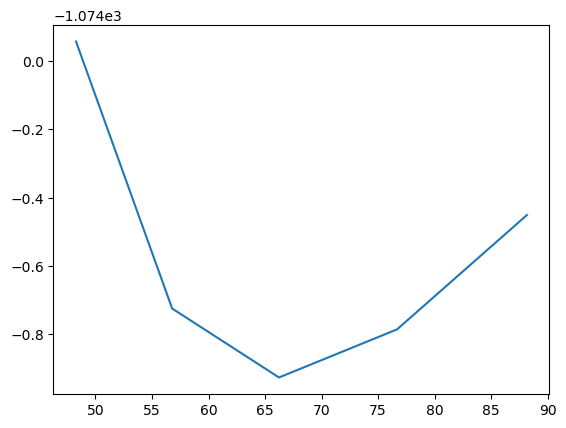

In [24]:
import matplotlib.pyplot as plt

plt.plot(volumes, energies)

## Work chain version

In [25]:
@engine.calcfunction
def create_eos_dictionary(**kwargs) -> orm.Dict:
    eos = {
        label: (result['volume'], result['energy'])
        for label, result in kwargs.items()
    }
    return orm.Dict(eos)

In [26]:
create_eos_dictionary(**results).get_dict()

{'structure_0': [48.283007573324, -1073.9421694118],
 'structure_1': [56.785519366503, -1074.7251942208],
 'structure_2': [66.231834805659, -1074.9273047095],
 'structure_3': [76.671627766898, -1074.7863009779],
 'structure_4': [88.154572126333, -1074.451028786]}

In [27]:
class EquationOfState(engine.WorkChain):
    """WorkChain to compute Equation of State using Quantum ESPRESSO."""

    @classmethod
    def define(cls, spec):
        """Specify inputs and outputs."""
        super().define(spec)
        spec.input("code", valid_type=orm.Code)
        spec.input("structure", valid_type=orm.StructureData)
        spec.input("scale_factors", valid_type=orm.List)

        spec.outline(
            cls.run_eos,
            cls.results,
        )
        spec.output("eos_dict", valid_type=orm.Dict)

    def run_eos(self):

        calcjob_dict = {}

        for label, rescaled_structure in rescale_list(self.inputs.structure, self.inputs.scale_factors).items():

            builder = PwCalculation.get_builder()
            builder.code = self.inputs.code
            builder.structure = rescaled_structure
            builder.parameters = orm.Dict(scf_inputs)
            builder.pseudopotentials = orm.Dict({"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
            builder.metadata.options.resources = resources

            calcjob_dict[label] = self.submit(builder)

        self.ctx.labels = list(calcjob_dict.keys())

        return calcjob_dict

    def results(self):

        self.report(self.ctx)

        eos_results = {
            label: self.ctx[label].outputs['properties'] for label in self.ctx.labels
        }
        eos_dict = create_eos_dictionary(**eos_results)
        self.out('eos_dict', eos_dict)


In [28]:
engine.run(EquationOfState, code=orm.load_code('pw@localhost'),
           structure=relaxed_structure,
           scale_factors=orm.List([0.9, 0.95, 1.0, 1.05, 1.1]))

01/29/2024 05:30:20 PM <1061> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [85|EquationOfState|results]: AttributeDict({'labels': ['structure_0', 'structure_1', 'structure_2', 'structure_3', 'structure_4'], 'structure_0': <CalcJobNode: uuid: b50287be-dbbb-4f74-8a46-e2d7305ee759 (pk: 94) (aiida.calculations:qe.pw)>, 'structure_1': <CalcJobNode: uuid: da9ee92e-892e-4720-83e7-311104f1444e (pk: 97) (aiida.calculations:qe.pw)>, 'structure_2': <CalcJobNode: uuid: 126b8db4-ad87-424e-bea0-3528f90ed72e (pk: 100) (aiida.calculations:qe.pw)>, 'structure_3': <CalcJobNode: uuid: 7b245b72-13be-4d90-b611-6b27c29ed483 (pk: 103) (aiida.calculations:qe.pw)>, 'structure_4': <CalcJobNode: uuid: 605ec335-8d8b-405c-b7d8-ac75d54e5caa (pk: 106) (aiida.calculations:qe.pw)>})


{'eos_dict': <Dict: uuid: c029d822-22a0-4993-9389-2472221be6dc (pk: 128)>}

## Using the `builder`

In [29]:
builder = EquationOfState.get_builder()

In [30]:
builder.structure = relaxed_structure

In [31]:
builder

Process class: EquationOfState
Inputs:
metadata: {}
structure: Al


In [32]:
builder.scale_factors = orm.List([0.9, 0.95, 1.0, 1.05, 1.1])
builder.code = orm.load_code('pw@localhost')

In [33]:
results, node = engine.run_get_node(builder)

01/29/2024 05:30:50 PM <1061> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [130|EquationOfState|results]: AttributeDict({'labels': ['structure_0', 'structure_1', 'structure_2', 'structure_3', 'structure_4'], 'structure_0': <CalcJobNode: uuid: aa95f594-5a5b-401c-a6cf-32450df4a23b (pk: 139) (aiida.calculations:qe.pw)>, 'structure_1': <CalcJobNode: uuid: 1110bd74-171e-4d80-bef6-940faaaf2f89 (pk: 142) (aiida.calculations:qe.pw)>, 'structure_2': <CalcJobNode: uuid: b9f651be-7c82-438a-b6db-6026eca68625 (pk: 145) (aiida.calculations:qe.pw)>, 'structure_3': <CalcJobNode: uuid: 88d79985-41ba-4ba0-a3bf-4693c9a16a4f (pk: 148) (aiida.calculations:qe.pw)>, 'structure_4': <CalcJobNode: uuid: b0b26dae-6bec-4fc5-a54f-4cdb725179a2 (pk: 151) (aiida.calculations:qe.pw)>})


In [34]:
results['eos_dict'].get_dict()

{'structure_0': [48.283007573324, -1073.9421694118],
 'structure_1': [56.785519366503, -1074.7251942208],
 'structure_2': [66.231834805659, -1074.9273047095],
 'structure_3': [76.671627766898, -1074.7863009779],
 'structure_4': [88.154572126333, -1074.451028786]}

In [35]:
eos = node.outputs.eos_dict.get_dict()

In [36]:
eos

{'structure_0': [48.283007573324, -1073.9421694118],
 'structure_1': [56.785519366503, -1074.7251942208],
 'structure_2': [66.231834805659, -1074.9273047095],
 'structure_3': [76.671627766898, -1074.7863009779],
 'structure_4': [88.154572126333, -1074.451028786]}

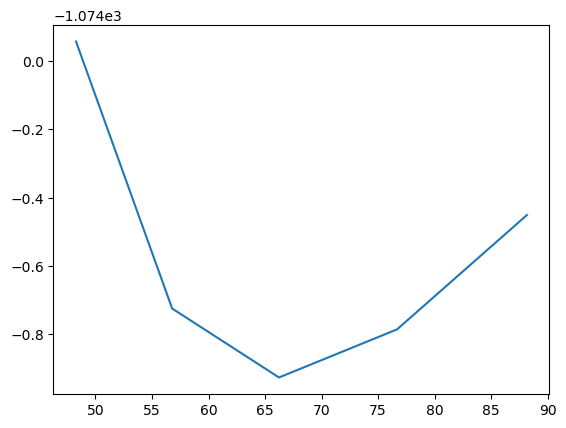

In [37]:
plt.plot(
    [v[0] for v in eos.values()],
    [v[1] for v in eos.values()],
)